In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import SimpleITK as sitk
from util import read_sitk, plot_ct, xyz2irc
import os 
from tqdm import  tqdm

In [2]:
SPACING = [1.0, 1.0, 1.0]   # resampling 1mmx1mmx1mm

### Create Extend box (drop background)

In [3]:
def create_extendbox(img_mask, old_spacing, new_spacing=SPACING):
    m1 = img_mask == 3
    m2 = img_mask == 4

    Mask = m1 + m2
    xx, yy, zz = np.where(Mask)

    newshape = np.round(np.array(Mask.shape)*old_spacing/new_spacing).astype('int') 
    box = np.array([[np.min(xx),np.max(xx)],[np.min(yy),np.max(yy)],[np.min(zz),np.max(zz)]])
    # print(np.array(old_spacing)/np.array(new_spacing))
    # print(box)
    box = box * (np.array(old_spacing)/np.array(new_spacing)).reshape((-1, 1))
    # box = box*np.array(old_spacing)/np.array(new_spacing)
    box = np.floor(box).astype('int')
    margin = 5
    extendbox = np.vstack([np.max([[0,0,0],box[:,0]-margin],0),np.min([newshape,box[:,1]+margin],axis=0).T]).T

    return extendbox


### Resampling

In [4]:
from scipy import ndimage

In [5]:
def rescale_spacing(image, old_spacing, new_spacing):
    # Tính toán tỷ lệ thay đổi spacing
    scale_factor = np.array(old_spacing) / np.array(new_spacing)

    # Tính toán kích thước mới của ảnh CT
    new_shape = np.round(image.shape * scale_factor)
    new_shape = new_shape.astype(int)

    # Thay đổi kích thước ảnh CT bằng phương pháp nội suy
    resized_image = ndimage.zoom(image, scale_factor, mode='nearest')

    return resized_image


# main function
def resampling(img, old_spacing, new_spacing=SPACING):

    resized_img = rescale_spacing(img, old_spacing, new_spacing)

    return resized_img

### Mask nodule

In [6]:
import os
os.chdir("mask")
os.getcwd()
import mask_nodule as mask_nodule
os.chdir("../")
os.getcwd()

'g:\\Explore_data\\data_processing'

### Normalize

In [7]:
def normalize(img):
    # clip image
    new_img = np.copy(img)
    new_img = np.clip(new_img, -1100, 200)

    # normalization min-max normalization
    minn = new_img.min()
    maxx = new_img.max()
    # max_min = maxx - minn

    return (new_img - minn) / (maxx - minn)

### Pipeline processing

In [16]:
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def pipe_line(subset, mask_values=[], save_path="../../luna16/full_processing"):
    luna_paths = glob.glob(f"../../luna16/LUNA16/subset{subset}/*.mhd")
    annotation = pd.read_csv("../../luna16/annotations.csv")

    for path in tqdm(luna_paths):
        # check folder exists
        if not os.path.exists(save_path + f"/subset{subset}"):
            os.makedirs(save_path + f"/subset{subset}")
        if not os.path.exists(save_path + f"/subset{subset}-gt"):
            os.makedirs(save_path + f"/subset{subset}-gt")        

        uid = path.split("\\")[-1][:-4]
        # uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"
        mask_path = glob.glob(f"../../luna16/seg-lungs-LUNA16/{uid}.mhd")[0]
        ctr_path = glob.glob(f"../../luna16/annotation/mask_test/{uid}.npy")[0]
        img_mask, _, _, _ = read_sitk(mask_path)

        img, origin,  spacing, direction = read_sitk(path)

        # check and flip 
        simple_direction = np.array((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
        direction = np.round(np.array(direction))
        if not np.array_equal(simple_direction, direction):
            img_mask = img_mask[:, ::-1, ::-1]
            img = img[:, ::-1, ::-1]

        # create extendbox
        extendbox = create_extendbox(img_mask, spacing)
        
        # caculation center mask in extendbox 
        this_annos = annotation[annotation['seriesuid'] == uid].drop(columns='seriesuid').to_numpy()
        label = []
        if len(this_annos) > 0:
            for c in this_annos:
                pos = worldToVoxelCoord(c[:3][::-1],origin=origin,spacing=spacing)
                if not np.array_equal(simple_direction, direction):
                    pos[1:] = img_mask.shape[1:3]-pos[1:]
                label.append(np.concatenate([pos,[c[3]/spacing[1]]]))
        
        if len(label) == 0:
            label1 = np.array([0, 0, 0, 0])
        else:
            label1 = np.copy(label).T
            label1[:3] = label1[:3]*((spacing/SPACING).reshape((-1, 1)))
            label1[3] = label1[3]*spacing[1]/SPACING[1]
            label1[:3] = label1[:3] - np.expand_dims(extendbox[:,0],1)
            label1 = label1.T
        
        # break

        # create nodule mask

        img_nodule_mask, _ = mask_nodule.nodule_mask(path, ctr_path)

        ## full preprocessing
        # img_normalize = normalize(img)
        
        d1 = img_mask == 3
        d2 = img_mask == 4
        img_mask_pulmonary = d1 + d2
        img_pulmonary = img * img_mask_pulmonary

        # resampling
        img_resampling = resampling(img_pulmonary, spacing)
        mask = resampling(img_nodule_mask, spacing)
        mask = np.round(mask)
        mask_values.append(np.unique(mask))

        # extendbox
        img_clean = img_resampling[extendbox[0,0]:extendbox[0,1],
                                    extendbox[1,0]:extendbox[1,1],
                                    extendbox[2,0]:extendbox[2,1]]
        mask =  mask[extendbox[0,0]:extendbox[0,1],
                    extendbox[1,0]:extendbox[1,1],
                    extendbox[2,0]:extendbox[2,1]]

        # normalize
        img_normalize = normalize(img_clean)

        # print(img_clean.shape)
        # print(extendbox)
        # print(origin)
        # print(label1)

        # get pos
        pos = []
        for i in range(mask.shape[0]):
            if 1 in mask[i]:
                pos.append(i)

        # save
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_clean.npy"), img_normalize)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_extendbox.npy"), extendbox)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_origin.npy"), origin)
        np.save(os.path.join(save_path, f"subset{subset}/{uid}_label.npy"), label1)

        # save mask
        np.save(os.path.join(save_path, f"subset{subset}-gt/{uid}_gt.npy"), mask)
        np.save(os.path.join(save_path, f"subset{subset}-gt/{uid}_posindex.npy"), pos)

    return mask_values
    
mask_values = pipe_line(0)

100%|██████████| 89/89 [1:21:49<00:00, 55.16s/it]


In [17]:
a = np.array(mask_values)
a
# np.unique(a)

C:\Users\ninhd\AppData\Local\Temp\ipykernel_14580\3215110946.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(mask_values)


array([array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]),
       array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]),
       array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]),
       array([0., 1.]), array([0., 1.]), array([-0.,  1.]), array([0.]),
       array([0., 1.]), array([0.]), array([0., 1.]), array([0., 1.]),
       array([-0.,  1.]), array([0., 1.]), array([-0.,  1.]),
       array([0., 1.]), array([0.]), array([-0.,  1.]), array([0.]),
       array([0., 1.]), array([0., 1.]), array([-0.,  1.]),
       array([0., 1.]), array([0., 1.]), array([-0.,  1.]),
       array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0.]),
       array([-0.,  1.]), array([0.]), array([0., 1.]), array([-0.,  1.]),
       array([0.]), array([0.]), array([0., 1.]), array([0., 1.]),
       array([-0.,  1.]), array([0., 1.]), array([-0.,  1.]),
       array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]),
       array([0.]), array([0.]

### Test

In [18]:
test_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"
# luna_path = 
paths = glob.glob(f"../../luna16/full_processing/subset0/*_clean.npy")[0]
index = np.load(glob.glob(f"../../luna16/full_processing/subset0-gt/*_posindex.npy")[0])

img = np.load(paths[0])

# plt.imshow(img[180])
# plt.show()
print(index)

plot_ct(img, index)

PermissionError: [Errno 13] Permission denied: '.'

[0. 1.]
[ 44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205]


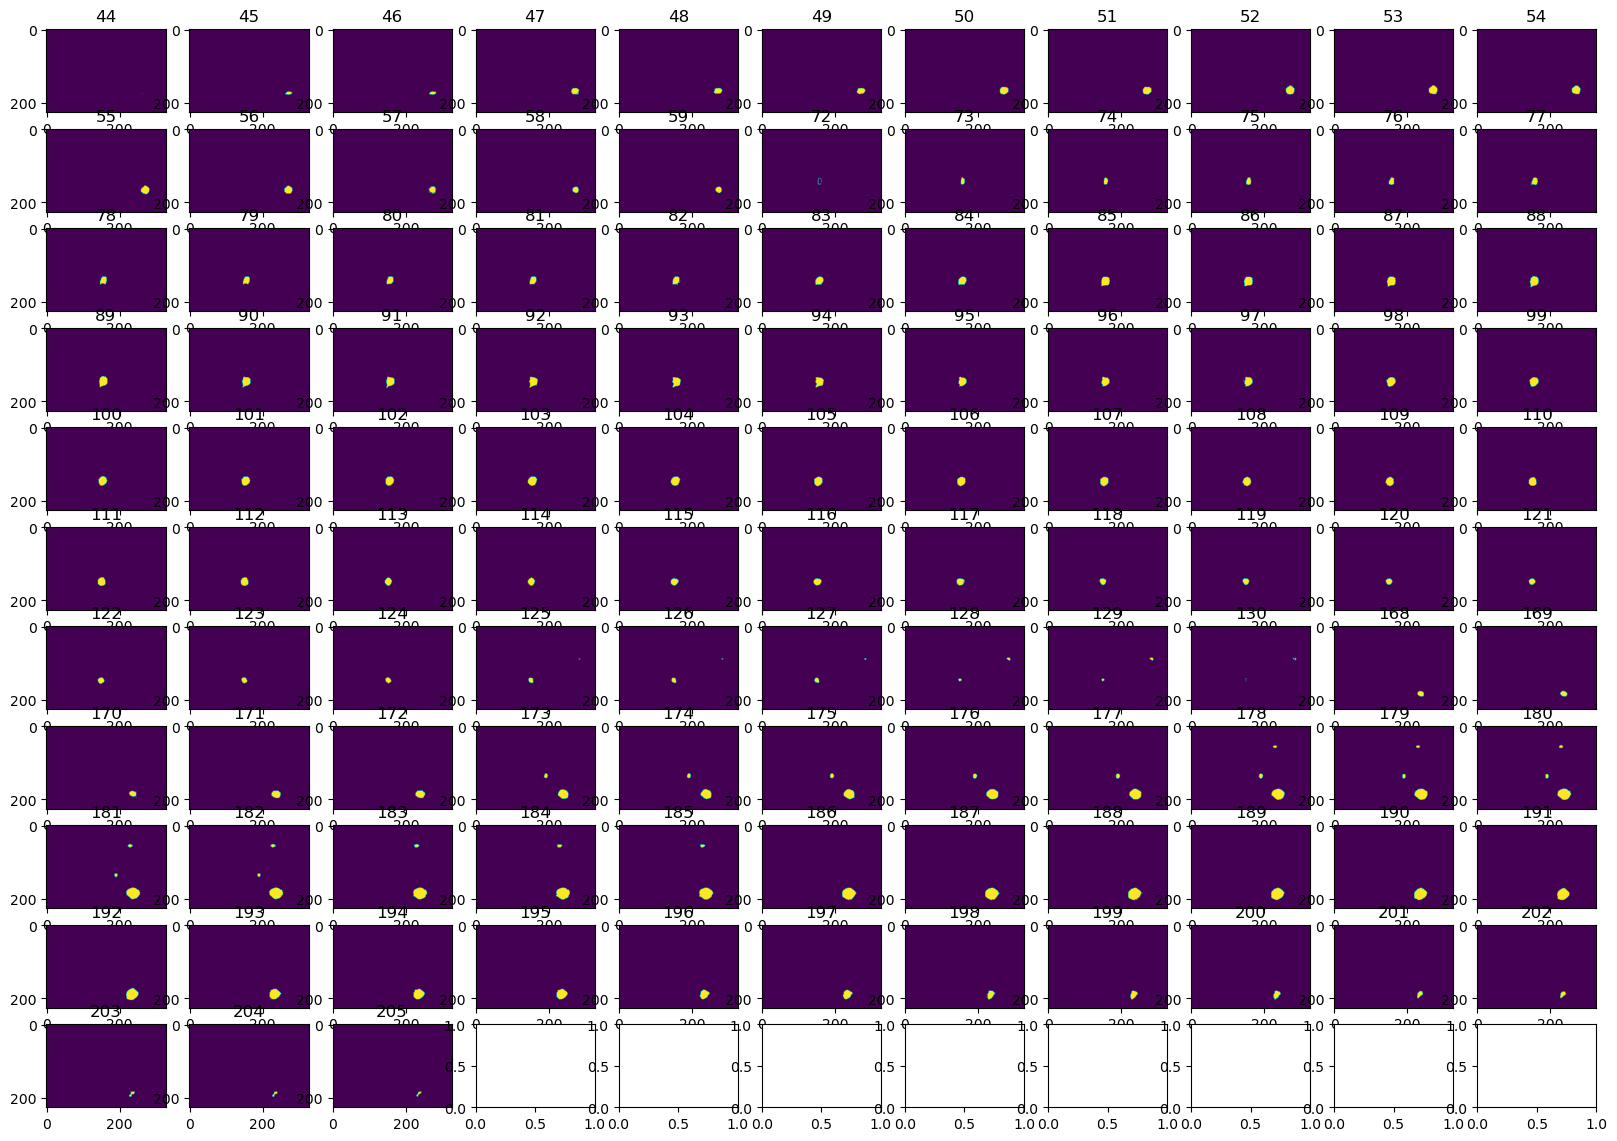

In [11]:
# mask
paths = glob.glob(f"../../luna16/full_processing/subset0-gt/*_gt.npy")[0]
index = np.load(glob.glob(f"../../luna16/full_processing/subset0-gt/*_posindex.npy")[0])
img = np.load(paths)

print(np.unique(img))
print(index)

# plt.imshow(img[180])
# plt.show()

plot_ct(img, index)